# 04 — Final Report: E-Commerce Funnel Optimization

**Objective:** Translate the analysis outputs into a stakeholder-ready report that highlights funnel drop-off, customer value, and high-ROI optimization opportunities.

**Data Source:** UCI Online Retail Dataset (2010–2011)

**Pipeline Dependency:** This notebook loads outputs produced by:
- `02_data_cleaning.ipynb`
- `03_funnel_analysis.ipynb`

## Executive Summary

This report summarizes results from an e-commerce funnel analysis using one year of transaction data from a UK-based online retailer.

The analysis focuses on:
- **Retention funnel**: first-time → repeat → high-value customers  
- **Customer value concentration**: how revenue is distributed across customers  
- **RFM segmentation**: identifying Champions / Loyal / At Risk customers  
- **Product performance**: top revenue products and revenue concentration  
- **Returns**: scale and signals for operational improvement  

**Main idea:** The highest ROI opportunities typically come from improving **repeat purchases** and targeting retention efforts by customer segment (especially high-value and at-risk customers).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Load pipeline outputs
# ----------------------------
cleaned = pd.read_csv("../data/processed/cleaned_purchases.csv")
customers = pd.read_csv("../data/processed/customer_metrics.csv")
products = pd.read_csv("../data/processed/product_performance.csv")
rfm = pd.read_csv("../data/processed/rfm_analysis.csv")
returns = pd.read_csv("../data/processed/returns.csv")

print("✅ Loaded files:")
print("cleaned:", cleaned.shape)
print("customers:", customers.shape)
print("products:", products.shape)
print("rfm:", rfm.shape)
print("returns:", returns.shape)

# ----------------------------
# Validate expected columns
# ----------------------------
expected = {
    "cleaned": {"CustomerID", "InvoiceNo", "InvoiceDate", "TotalPrice", "Country"},
    "customers": {"CustomerID", "NumOrders", "TotalSpent", "MonthsActive"},
    "products": {"Description", "Revenue", "TotalQuantity", "NumOrders"},
    "rfm": {"CustomerID", "Recency", "Frequency", "Monetary", "Segment"},
    "returns": {"CustomerID", "InvoiceNo", "InvoiceDate", "Quantity", "UnitPrice"}
}

actual = {
    "cleaned": set(cleaned.columns),
    "customers": set(customers.columns),
    "products": set(products.columns),
    "rfm": set(rfm.columns),
    "returns": set(returns.columns)
}

missing = {k: sorted(list(expected[k] - actual[k])) for k in expected}
print("\n🔎 Missing columns check:")
for k, v in missing.items():
    print(f"{k}: {v if v else 'None ✅'}")

# Quick previews (for confidence)
print("\n👀 Preview: customers")
display(customers.head())

print("\n👀 Preview: rfm")
display(rfm.head())

print("\n👀 Preview: products")
display(products.head())

✅ Loaded files:
cleaned: (392119, 15)
customers: (4277, 8)
products: (3889, 5)
rfm: (4277, 9)
returns: (8905, 9)

🔎 Missing columns check:
cleaned: None ✅
customers: None ✅
products: ['NumOrders']
rfm: None ✅
returns: None ✅

👀 Preview: customers


,CustomerID,NumOrders,TotalSpent,FirstPurchase,LastPurchase,MonthsActive,DaysSinceFirst,CustomerSegment
0,12347.0,7,4060.40,2010-12-07 14:57:00,2011-12-07 15:52:00,7,365,International
1,12348.0,4,1306.68,2010-12-16 19:09:00,2011-09-25 13:13:00,4,282,International
2,12349.0,1,1457.55,2011-11-21 09:51:00,2011-11-21 09:51:00,1,0,International
3,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,1,0,International
4,12352.0,8,1849.49,2011-02-16 12:33:00,2011-11-03 14:37:00,4,260,International



👀 Preview: rfm


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Total,Segment
0,12347.0,2,7,4060.40,5,5,5,15,Champions
1,12348.0,75,4,1306.68,2,4,4,10,Big Spenders
2,12349.0,19,1,1457.55,4,1,4,9,Promising
3,12350.0,310,1,334.40,1,1,2,4,At Risk
4,12352.0,36,8,1849.49,3,5,4,12,Big Spenders



👀 Preview: products


,StockCode,Description,TotalQuantity,Revenue,Orders
0,10002,INFLATABLE POLITICAL GLOBE,823,699.55,49
1,10080,GROOVY CACTUS INFLATABLE,291,114.41,21
2,10120,DOGGY RUBBER,193,40.53,29
3,10123C,HEARTS WRAPPING TAPE,5,3.25,3
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,6.72,5


## Data Context & Cleaning Summary

The original dataset contains ~541K transaction rows. Cleaning was necessary to support customer-level funnel analysis.

### Cleaning outcomes (from notebook 02)
- Removed transactions without CustomerID (~25%)
- Separated return/cancellation transactions (~2%)
- Removed outliers / invalid records
- Produced a clean purchases table used for downstream analysis

These steps ensure funnel metrics reflect **real identifiable customer behavior**.

In [2]:
raw_like_total = len(cleaned) + len(returns)
removed_est = 541_909 - raw_like_total  # reference from dataset size
returns_rate = len(returns) / (len(cleaned) + len(returns)) * 100

print("=== Cleaning Summary (computed from saved outputs) ===")
print(f"Clean purchase rows: {len(cleaned):,}")
print(f"Return rows:         {len(returns):,}")
print(f"Total remaining:     {raw_like_total:,}")
print(f"Approx removed vs raw 541,909: {removed_est:,} rows")
print(f"Returns rate (approx): {returns_rate:.2f}%")

=== Cleaning Summary (computed from saved outputs) ===
Clean purchase rows: 392,119
Return rows:         8,905
Total remaining:     401,024
Approx removed vs raw 541,909: 140,885 rows
Returns rate (approx): 2.22%


## Customer Funnel Results

Because the dataset is transactional (not web-event data), we define a **retention funnel** based on customer purchase behavior:

1. **Active Customers**: customers with ≥1 order  
2. **Engaged Customers**: customers with ≥2 orders  
3. **Repeat Customers**: customers active in ≥2 distinct months  
4. **High-Value Customers**: top 20% by total spend  

This funnel isolates the key business problem: **retention**.

,Stage,Count,ConversionRate_%,DropOff,DropOffRate_%
0,Active Customers,4277,100.00,0,NaN
1,Engaged (2+ Orders),2796,65.37,1481,34.63
2,Repeat (2+ Months),2664,62.29,132,4.72
3,High-Value (Top 20%),856,20.01,1808,67.87


High-value threshold (Top 20%) = £1,903.87


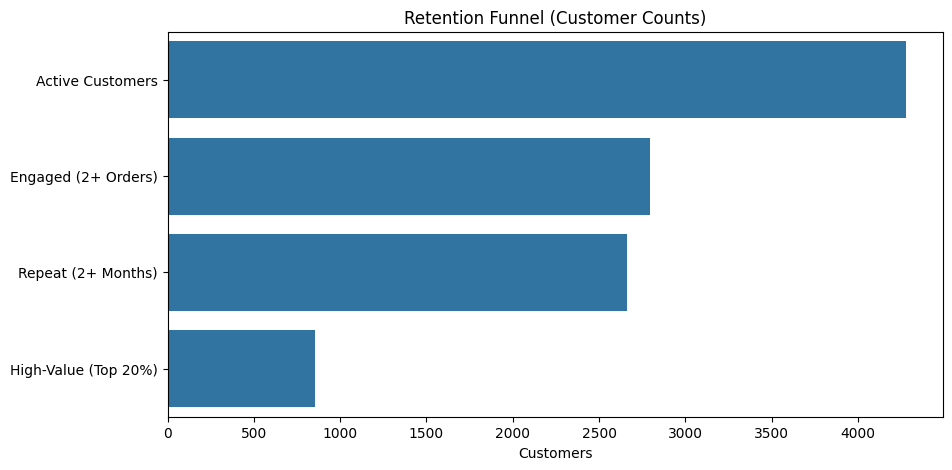

In [3]:
total_customers = len(customers)
engaged = (customers["NumOrders"] >= 2).sum()
repeat = (customers["MonthsActive"] >= 2).sum()

high_value_threshold = customers["TotalSpent"].quantile(0.80)
high_value = (customers["TotalSpent"] >= high_value_threshold).sum()

funnel = pd.DataFrame({
    "Stage": ["Active Customers", "Engaged (2+ Orders)", "Repeat (2+ Months)", "High-Value (Top 20%)"],
    "Count": [total_customers, engaged, repeat, high_value]
})

funnel["ConversionRate_%"] = (funnel["Count"] / total_customers * 100).round(2)
funnel["DropOff"] = funnel["Count"].diff().abs().fillna(0).astype(int)
funnel["DropOffRate_%"] = (funnel["DropOff"] / funnel["Count"].shift(1) * 100).round(2)

display(funnel)
print(f"High-value threshold (Top 20%) = £{high_value_threshold:,.2f}")

plt.figure(figsize=(10, 5))
sns.barplot(data=funnel, x="Count", y="Stage")
plt.title("Retention Funnel (Customer Counts)")
plt.xlabel("Customers")
plt.ylabel("")
plt.show()

### Funnel Interpretation

The biggest drop-off usually occurs after the first purchase.  
This suggests the strongest ROI comes from improving the **second purchase rate** (retention), because it grows revenue without requiring new customer acquisition.

## Customer Value Concentration

Most marketplaces show a skewed spending distribution: a minority of customers contribute a large share of revenue.

We quantify:
- Spend distribution shape  
- Revenue share contributed by top 10% and top 1% customers  

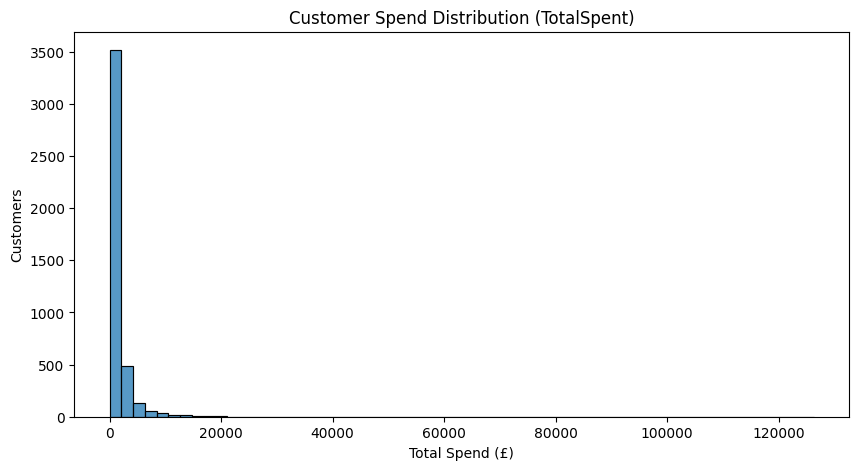

=== Revenue Concentration ===
Total revenue (customer spend): £6,545,566.90
Top 10% customers revenue share: 51.8%
Top 1% customers revenue share:  19.2%


count      4277.000000
mean       1530.410780
std        4108.020739
min           2.900000
25%         291.050000
50%         642.410000
75%        1545.620000
max      126386.360000
Name: TotalSpent, dtype: float64

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(customers["TotalSpent"], bins=60)
plt.title("Customer Spend Distribution (TotalSpent)")
plt.xlabel("Total Spend (£)")
plt.ylabel("Customers")
plt.show()

rev_total = customers["TotalSpent"].sum()
top_10pct_cut = customers["TotalSpent"].quantile(0.90)
top_1pct_cut = customers["TotalSpent"].quantile(0.99)

rev_top10 = customers.loc[customers["TotalSpent"] >= top_10pct_cut, "TotalSpent"].sum()
rev_top1 = customers.loc[customers["TotalSpent"] >= top_1pct_cut, "TotalSpent"].sum()

print("=== Revenue Concentration ===")
print(f"Total revenue (customer spend): £{rev_total:,.2f}")
print(f"Top 10% customers revenue share: {rev_top10 / rev_total * 100:.1f}%")
print(f"Top 1% customers revenue share:  {rev_top1 / rev_total * 100:.1f}%")

display(customers["TotalSpent"].describe())

## RFM Segmentation (Recency, Frequency, Monetary)

RFM groups customers based on:
- **Recency:** how recently they purchased
- **Frequency:** how often they purchase
- **Monetary:** how much they spend

This allows targeted strategies:
- protect high-value customers
- win back at-risk customers
- avoid wasting marketing spend on low-probability segments

,Customers,AvgRecency,AvgFrequency,AvgMonetary,TotalRevenue
Segment,,,,,
At Risk,1541,199.25,1.58,460.61,709800.82
Champions,959,13.11,10.70,4321.21,4144043.57
Need Attention,598,52.26,1.87,573.78,343120.28
Loyal,475,15.84,2.88,690.49,327982.19
Big Spenders,391,80.29,5.96,2274.75,889426.21
Promising,313,18.75,1.24,419.15,131193.83


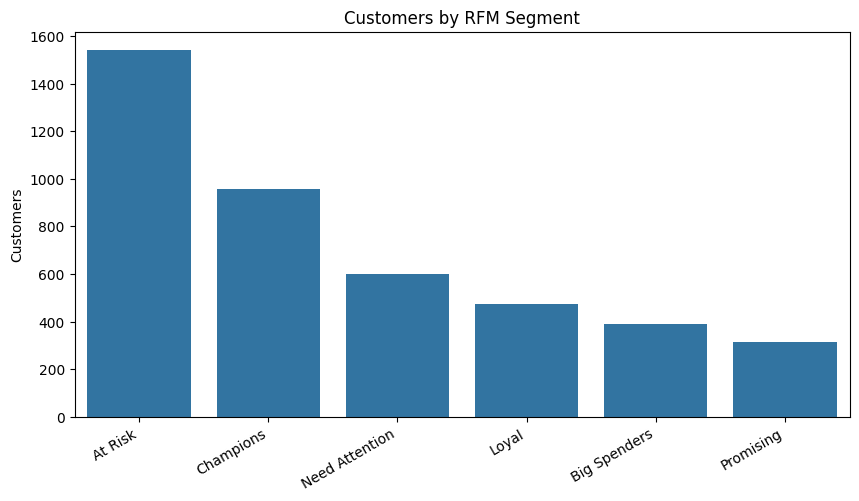

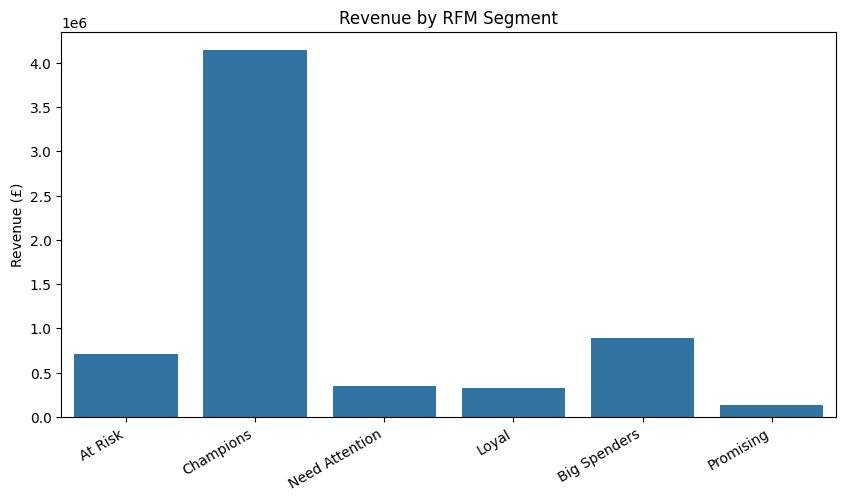

=== Revenue Share by Segment (%) ===


Segment
Champions         63.31
Big Spenders      13.59
At Risk           10.84
Need Attention     5.24
Loyal              5.01
Promising          2.00
Name: TotalRevenue, dtype: float64

In [5]:
segment_summary = rfm.groupby("Segment").agg(
    Customers=("CustomerID", "count"),
    AvgRecency=("Recency", "mean"),
    AvgFrequency=("Frequency", "mean"),
    AvgMonetary=("Monetary", "mean"),
    TotalRevenue=("Monetary", "sum"),
).sort_values("Customers", ascending=False)

display(segment_summary.round(2))

plt.figure(figsize=(10, 5))
sns.barplot(x=segment_summary.index, y=segment_summary["Customers"])
plt.title("Customers by RFM Segment")
plt.xlabel("")
plt.ylabel("Customers")
plt.xticks(rotation=30, ha="right")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=segment_summary.index, y=segment_summary["TotalRevenue"])
plt.title("Revenue by RFM Segment")
plt.xlabel("")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=30, ha="right")
plt.show()

rev_total = segment_summary["TotalRevenue"].sum()
rev_share = (segment_summary["TotalRevenue"] / rev_total * 100).sort_values(ascending=False)
print("=== Revenue Share by Segment (%) ===")
display(rev_share.round(2))

## Product Performance

We analyze product revenue contribution to understand:
- which products drive revenue the most
- how concentrated revenue is (dependency risk)
- what should be protected via inventory and merchandising

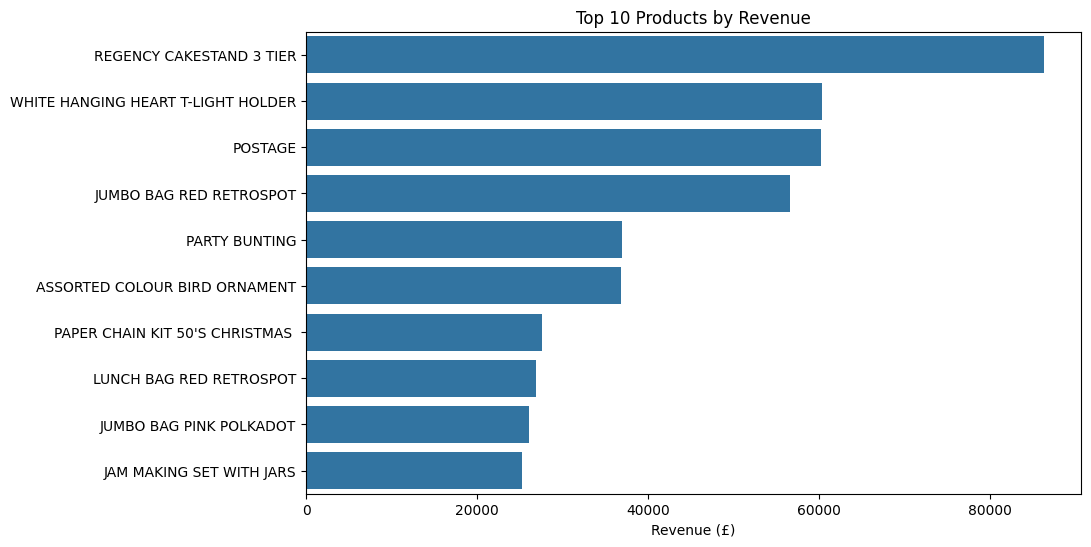

Top 10 products revenue share: 6.8%


In [6]:
top_products = products.sort_values("Revenue", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_products, x="Revenue", y=top_products["Description"].str[:45])
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue (£)")
plt.ylabel("")
plt.show()

top10_rev = top_products["Revenue"].sum()
total_rev = products["Revenue"].sum()
print(f"Top 10 products revenue share: {top10_rev / total_rev * 100:.1f}%")

## Returns Overview

Returns/cancellations represent operational and customer experience signals.

We evaluate:
- approximate return transaction rate
- where returns are most common (country/product if available)

In [7]:
returns_rate = len(returns) / (len(returns) + len(cleaned)) * 100
print(f"Return transaction rate (approx): {returns_rate:.2f}%")

if "Country" in returns.columns:
    print("\nTop return countries:")
    display(returns["Country"].value_counts().head(10))

if "Description" in returns.columns:
    print("\nTop returned products:")
    display(returns["Description"].value_counts().head(10))

Return transaction rate (approx): 2.22%

Top return countries:


Country
United Kingdom    7533
Germany            453
EIRE               247
France             149
USA                112
Australia           74
Spain               48
Italy               45
Belgium             38
Japan               37
Name: count, dtype: int64


Top returned products:


Description
REGENCY CAKESTAND 3 TIER              181
Manual                                175
POSTAGE                                97
JAM MAKING SET WITH JARS               86
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       73
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        53
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
Name: count, dtype: int64

## Business Recommendations

1) **Increase second-purchase conversion**
- Trigger post-purchase follow-ups within 7–14 days
- Add loyalty incentives (points, discounts, free shipping thresholds)

2) **Segment marketing by RFM**
- **Champions/Loyal:** VIP perks, personalization, early access
- **At Risk:** win-back campaigns with time-limited offers
- Reduce broad campaigns to avoid wasted spend

3) **Manage product revenue concentration**
- Ensure best-sellers have strong inventory + merchandising
- Bundle best-sellers with mid-tier products to diversify revenue

4) **Use returns as a quality signal**
- Monitor high-return SKUs for packaging/description/quality improvements
- Flag international return patterns as potential shipping or expectation gaps

## Limitations & Next Steps

**Limitations**
- Transaction data does not contain true web funnel events (views/cart/checkout)
- Transactions without CustomerID were removed, so anonymous behavior is excluded

**Next Steps**
- Add cohort retention analysis (monthly cohorts)
- Add country-level retention comparisons (UK vs International) directly in the report
- If event-level data becomes available, rebuild a true web funnel

## Conclusion

This project demonstrates a reproducible pipeline:
**Exploration → Cleaning → Analysis Outputs → Final Reporting**

The results point toward retention as the primary lever: increasing the second purchase rate and targeting RFM segments can significantly improve revenue efficiency.